In [1]:
#Preparing the events data
import csv

csv_file_path = "./holidays_events.csv"
data_dict = {}

with open(csv_file_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=",")
    
    for row in csv_reader:
        date = row["date"]
        locale_name = row["locale_name"]
        
        if date not in data_dict:
            data_dict[date] = {}
            
        description = row["description"]
        change = None
        if '+' in description:
            if any(char.isdigit() for char in description):
                phrases = description.split("+")
                description = phrases[0]
                change = int(phrases[1])+1
        if '-' in description:
            if any(char.isdigit() for char in description):
                phrases = description.split("-")
                description = phrases[0]
                change = '-' + phrases[1]
                #print(change)
        else:
            try:
                description = description
            except ValueError:
                description = description
            
        data_dict[date][locale_name] = {
            "type": row["type"],
            "locale": row["locale"],
            "description": description,
            "transferred": row["transferred"],
            "change": change,
        }

In [2]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime
from calendar import monthrange

# Load the CSV file using pandas
train_df = pd.read_csv('train.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
# fill missing values in dcoilwtico column with previous day's value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
merged_df = pd.merge(train_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
merged_df['dcoilwtico'] = merged_df['dcoilwtico'].fillna(method='ffill')
merged_df = pd.merge(merged_df, stores_df, on='store_nbr').sort_values(by='id')

df = merged_df#pd.read_csv('train.csv')

# Extract the label column and convert to a PyTorch tensor
ids = torch.tensor(df['id'].values, dtype=torch.float)
#date = torch.tensor(df['date'].values)
store_nbr = torch.tensor(df['store_nbr'].values)
train_sales = torch.tensor(df['sales'].values, dtype=torch.float)
onpromotion = torch.tensor(df['onpromotion'].values)
dcoilwtico = torch.tensor(df['dcoilwtico'].values, dtype=torch.float)

df['event_type'] = 'regular day'
df['description'] = '0'
for index, row in df.iterrows():
    if (row['date'] in data_dict):
        if (row['city'] in data_dict[row['date']]):
            df.at[index, 'description'] = data_dict[row['date']][row['city']]['description']
            df.at[index, 'event_type'] =  data_dict[row['date']][row['city']]['type']
        if (row['state'] in data_dict[row['date']]):
            df.at[index, 'description'] = data_dict[row['date']][row['state']]['description']
            df.at[index, 'event_type']  = data_dict[row['date']][row['state']]['type']
        if ('Ecuador' in data_dict[row['date']]):
                df.at[index, 'description'] = data_dict[row['date']]['Ecuador']['description']
                df.at[index, 'event_type'] = data_dict[row['date']]['Ecuador']['type']
    else:
        df.at[index, 'event_type'] = "regular day"
#df.to_csv('merged.csv', index=False)
# Convert string dates to datetime objects
dates = pd.to_datetime(df['date'], format='%Y-%m-%d')
month = []
day_of_week = []
day_of_month = []
day_since_paycheck = []
for i in dates:
    month.append(i.month)
    day_of_week.append(i.day_of_week + 1)
    num_days_in_month = monthrange(i.year, i.month)[1]
    day_of_month.append(i.day)
    if(num_days_in_month == i.day):
        day_since_paycheck.append(0)
    else:
        if (i.day>=15):
            day_since_paycheck.append(i.day-15)
        else:
            day_since_paycheck.append(i.day)

month = torch.FloatTensor(month)
day_of_week = torch.FloatTensor(day_of_week)
day_since_paycheck = torch.FloatTensor(day_since_paycheck)
day_of_month = torch.FloatTensor(day_of_month)

#family to tensor
family = []
family_raw = df['family'].values
families = sorted(list(set(family_raw)))
family_stoi = {s:i+1 for i,s in enumerate(families)}
for i in family_raw:
    family.append(family_stoi[i])
family = torch.FloatTensor(family)

#city to tensor
city = []
city_raw = df['city'].values
cities = sorted(list(set(city_raw)))
cities_stoi = {s:i+1 for i,s in enumerate(cities)}
#cities_itos = {i:s for s,i in cities_stoi.items()}
for i in city_raw:
    city.append(cities_stoi[i])
city = torch.FloatTensor(city)

#state to tensor
state_raw = df['state'].values
state = []
states = sorted(list(set(state_raw)))
states_stoi = {s:i+1 for i,s in enumerate(states)}
for i in state_raw:
    state.append(states_stoi[i])
state = torch.FloatTensor(state)

#store type to tensor
store_type_raw = df['type'].values
store_type = []
store_types = sorted(list(set(store_type_raw)))
store_types_stoi = {s:i+1 for i,s in enumerate(store_types)}
for i in store_type_raw:
    store_type.append(store_types_stoi[i])
store_type = torch.FloatTensor(store_type)

train_event_description_raw = df['description']
train_event_description = []
event_descriptions = sorted(list(set(train_event_description_raw)))
event_descriptions_stoi = {s:i+1 for i,s in enumerate(event_descriptions)}
for i in train_event_description_raw:
    train_event_description.append(event_descriptions_stoi[i])
train_event_description = torch.FloatTensor(train_event_description)


train_event_type_raw = df['event_type']
train_event_type = []
event_types = sorted(list(set(train_event_type_raw)))
event_types_stoi = {s:i+1 for i,s in enumerate(event_types)}
for i in train_event_type_raw:
    train_event_type.append(event_types_stoi[i])
train_event_type = torch.FloatTensor(train_event_type)


cluster = torch.tensor(df['cluster'].values, dtype=torch.float)
#merged_df.to_csv('merged.csv', index=False)

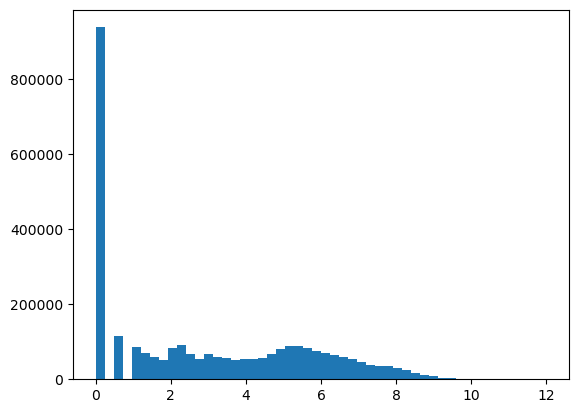

11.73381
tensor(2.6951)
0.0


In [3]:
import matplotlib.pyplot as plt
train_sales_log = np.log(train_sales+1)
data_range = train_sales_log.numpy().max() - train_sales_log.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales_log.numpy().max())+1)
plt.hist(train_sales_log.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(train_sales_log.std())
print(train_sales_log.numpy().min())

In [6]:
print(ids.shape, ids.dtype)
print(train_sales.shape, train_sales.dtype)
print(train_sales_log.shape, train_sales_log.dtype)
print(onpromotion.shape, onpromotion.dtype)
print(family.shape, family.dtype)
print(day_of_week.shape, day_of_week.dtype)
print(month.shape, month.dtype)
print(day_since_paycheck.shape, day_since_paycheck.dtype)
print(dcoilwtico.shape, dcoilwtico.dtype)
print(city.shape, city.dtype)
print(state.shape, state.dtype)
print(store_type.shape, store_type.dtype)
print(cluster.shape, cluster.dtype)
print(train_event_type.shape, train_event_type.dtype)
print(train_event_description.shape, train_event_description.dtype)

torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.int64
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32


In [7]:
train_data = torch.cat((month.unsqueeze(1), day_of_week.unsqueeze(1),day_since_paycheck.unsqueeze(1),
                        #store_nbr.unsqueeze(1),
                        family.unsqueeze(1),  onpromotion.unsqueeze(1),
                        dcoilwtico.unsqueeze(1),
                        city.unsqueeze(1), state.unsqueeze(1), store_type.unsqueeze(1), cluster.unsqueeze(1),
                        train_event_type.unsqueeze(1), train_event_description.unsqueeze(1)
                           ), dim=1)

print(train_data.dtype)
print(train_data.shape, train_data.dtype)
print(train_sales.shape, train_sales.dtype)

torch.float32
torch.Size([3000888, 12]) torch.float32
torch.Size([3000888]) torch.float32


In [8]:
# Shuffle the data and labels
indices = np.random.permutation(len(train_data))
train_data = train_data[indices]
train_sales = train_sales_log[indices]

# Define the percentage of data to be used for validation
val_percent = 0.2

# Calculate the number of validation samples
val_size = int(len(train_data) * val_percent)

# Split the data and labels into training and validation sets
val_data = train_data[:val_size]
train_data = train_data[val_size:]

val_sales = train_sales[:val_size]
train_sales = train_sales[val_size:]

print(val_data.shape)
print(val_sales.shape)
print(train_data.shape)
print(train_sales.shape)

torch.Size([600177, 12])
torch.Size([600177])
torch.Size([2400711, 12])
torch.Size([2400711])


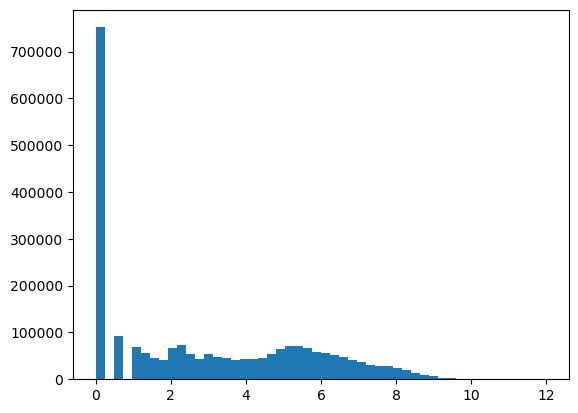

11.73381
std 2.6952431201934814
mean 2.9256398677825928
min 0.0
max 11.733810424804688


In [9]:
import matplotlib.pyplot as plt
data_range = train_sales.numpy().max() - train_sales.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales.numpy().max())+1)
plt.hist(train_sales.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(f'std {train_sales.std()}')
print(f'mean {train_sales.mean()}')
print(f'min {train_sales.min()}')
print(f'max {train_sales.max()}')

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [11]:
from torch import nn
import math

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        rmsle = self.mse(torch.log(pred + 1), torch.log(actual + 1)) 
        return rmsle


In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SalesPredictor(nn.Module):
    def __init__(self):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(12, 64) 
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1, bias=False)
        self.Leaky_ReLu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.Leaky_ReLu(x)
        x = self.fc3(x)
        x = self.Leaky_ReLu(x)
        x = self.fc4(x)
        x = self.relu(x)
        return x
    
    # Instantiate the neural network
model = SalesPredictor()
print(model)

SalesPredictor(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=False)
  (Leaky_ReLu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
)


In [13]:
from torch.utils.data import TensorDataset, DataLoader
# Define the loss function and optimizer
criterion = RMSLELoss()
optimizer = optim.Adam(model.parameters())

# Convert the data and labels to PyTorch datasets
train_dataset = TensorDataset(train_data, train_sales)
val_dataset = TensorDataset(val_data, val_sales)
# Define batch size for training and validation dataloaders
batch_size = 1300
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=10)
save_every = 1
train_iterations = 1000


In [14]:
running_loss_es = []

In [15]:
def train():
    for epoch in range(train_iterations):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            print (f'Training epoch {epoch} iteration {i} of {len(train_loader)}', end = '\r'),
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(-1)
            outputs = outputs.squeeze(-1)
            raw_out = outputs
            #returning to real values instead of logs
            labels = torch.exp(labels)-1
            outputs = torch.exp(outputs)-1
            loss = criterion(outputs, labels)
            if (math.isnan(loss)):
                print(f'inputs = {inputs}')
                print(f'outputs = {outputs}')
                print(f'raw outputs = {raw_out}')
                print(f'expected ={labels}')
                print(f'NaN error on epoch {epoch}\n')
                for param in model.parameters():
                    print(param.data)
                return
                break
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'\nEpoch {epoch} loss: {running_loss/len(train_loader)}')
        running_loss_es.append(running_loss/len(train_loader))
        if (epoch % save_every == 0):
            model_file_name = f'weights/model_weights_{epoch}.pth'
            print(f'Saving model as {model_file_name}')
            torch.save(model, model_file_name)
        torch.save(model, f'weights/model_weights_{train_iterations}.pth')
train()
print("Done")

Training epoch 0 iteration 1846 of 1847
Epoch 0 loss: 4.26310038463322
Saving model as weights/model_weights_0.pth
Training epoch 1 iteration 1846 of 1847
Epoch 1 loss: 3.5798740385672048
Saving model as weights/model_weights_1.pth
Training epoch 2 iteration 1846 of 1847
Epoch 2 loss: 3.258708684716795
Saving model as weights/model_weights_2.pth
Training epoch 3 iteration 1846 of 1847
Epoch 3 loss: 2.9242915432067194
Saving model as weights/model_weights_3.pth
Training epoch 4 iteration 1846 of 1847
Epoch 4 loss: 2.6349953901593466
Saving model as weights/model_weights_4.pth
Training epoch 5 iteration 1846 of 1847
Epoch 5 loss: 2.2921321408194855
Saving model as weights/model_weights_5.pth
Training epoch 6 iteration 1846 of 1847
Epoch 6 loss: 1.9925863458197635
Saving model as weights/model_weights_6.pth
Training epoch 7 iteration 1846 of 1847
Epoch 7 loss: 1.7875696503283465
Saving model as weights/model_weights_7.pth
Training epoch 8 iteration 1846 of 1847
Epoch 8 loss: 1.66140608937

Training epoch 69 iteration 1846 of 1847
Epoch 69 loss: 0.8199445732103274
Saving model as weights/model_weights_69.pth
Training epoch 70 iteration 1846 of 1847
Epoch 70 loss: 0.8169891774880286
Saving model as weights/model_weights_70.pth
Training epoch 71 iteration 1846 of 1847
Epoch 71 loss: 0.8127608543224573
Saving model as weights/model_weights_71.pth
Training epoch 72 iteration 1846 of 1847
Epoch 72 loss: 0.8110033355988098
Saving model as weights/model_weights_72.pth
Training epoch 73 iteration 1846 of 1847
Epoch 73 loss: 0.8084036785005942
Saving model as weights/model_weights_73.pth
Training epoch 74 iteration 1846 of 1847
Epoch 74 loss: 0.8056514612325928
Saving model as weights/model_weights_74.pth
Training epoch 75 iteration 1846 of 1847
Epoch 75 loss: 0.8044524515197932
Saving model as weights/model_weights_75.pth
Training epoch 76 iteration 1846 of 1847
Epoch 76 loss: 0.8004209550574591
Saving model as weights/model_weights_76.pth
Training epoch 77 iteration 1846 of 1847

Training epoch 137 iteration 1846 of 1847
Epoch 137 loss: 0.7150528918877123
Saving model as weights/model_weights_137.pth
Training epoch 138 iteration 1846 of 1847
Epoch 138 loss: 0.7126317798413647
Saving model as weights/model_weights_138.pth
Training epoch 139 iteration 1846 of 1847
Epoch 139 loss: 0.7145424844060773
Saving model as weights/model_weights_139.pth
Training epoch 140 iteration 1846 of 1847
Epoch 140 loss: 0.711994697548082
Saving model as weights/model_weights_140.pth
Training epoch 141 iteration 1846 of 1847
Epoch 141 loss: 0.7109798571194709
Saving model as weights/model_weights_141.pth
Training epoch 142 iteration 1846 of 1847
Epoch 142 loss: 0.7101856004436661
Saving model as weights/model_weights_142.pth
Training epoch 143 iteration 1846 of 1847
Epoch 143 loss: 0.7088472046075025
Saving model as weights/model_weights_143.pth
Training epoch 144 iteration 1846 of 1847
Epoch 144 loss: 0.7112428286169824
Saving model as weights/model_weights_144.pth
Training epoch 14

Training epoch 204 iteration 1846 of 1847
Epoch 204 loss: 0.673791617122804
Saving model as weights/model_weights_204.pth
Training epoch 205 iteration 1846 of 1847
Epoch 205 loss: 0.6725990043566817
Saving model as weights/model_weights_205.pth
Training epoch 206 iteration 1846 of 1847
Epoch 206 loss: 0.6716507012029564
Saving model as weights/model_weights_206.pth
Training epoch 207 iteration 1846 of 1847
Epoch 207 loss: 0.6709099870213445
Saving model as weights/model_weights_207.pth
Training epoch 208 iteration 1846 of 1847
Epoch 208 loss: 0.6704173698803509
Saving model as weights/model_weights_208.pth
Training epoch 209 iteration 1846 of 1847
Epoch 209 loss: 0.6713912394896158
Saving model as weights/model_weights_209.pth
Training epoch 210 iteration 1846 of 1847
Epoch 210 loss: 0.669941562556162
Saving model as weights/model_weights_210.pth
Training epoch 211 iteration 1846 of 1847
Epoch 211 loss: 0.6689587097976036
Saving model as weights/model_weights_211.pth
Training epoch 212

Training epoch 271 iteration 1846 of 1847
Epoch 271 loss: 0.6462280028532438
Saving model as weights/model_weights_271.pth
Training epoch 272 iteration 1846 of 1847
Epoch 272 loss: 0.6470608931492648
Saving model as weights/model_weights_272.pth
Training epoch 273 iteration 1846 of 1847
Epoch 273 loss: 0.6455381909253214
Saving model as weights/model_weights_273.pth
Training epoch 274 iteration 1846 of 1847
Epoch 274 loss: 0.6458076070661344
Saving model as weights/model_weights_274.pth
Training epoch 275 iteration 1846 of 1847
Epoch 275 loss: 0.6453125358079663
Saving model as weights/model_weights_275.pth
Training epoch 276 iteration 1846 of 1847
Epoch 276 loss: 0.6454359839978447
Saving model as weights/model_weights_276.pth
Training epoch 277 iteration 1846 of 1847
Epoch 277 loss: 0.6447961124201755
Saving model as weights/model_weights_277.pth
Training epoch 278 iteration 1846 of 1847
Epoch 278 loss: 0.6441536752772319
Saving model as weights/model_weights_278.pth
Training epoch 2

Training epoch 338 iteration 1846 of 1847
Epoch 338 loss: 0.6309259399795893
Saving model as weights/model_weights_338.pth
Training epoch 339 iteration 1846 of 1847
Epoch 339 loss: 0.6290485738223478
Saving model as weights/model_weights_339.pth
Training epoch 340 iteration 1846 of 1847
Epoch 340 loss: 0.628078159362352
Saving model as weights/model_weights_340.pth
Training epoch 341 iteration 1846 of 1847
Epoch 341 loss: 0.6279764653994835
Saving model as weights/model_weights_341.pth
Training epoch 342 iteration 1846 of 1847
Epoch 342 loss: 0.6287878179911607
Saving model as weights/model_weights_342.pth
Training epoch 343 iteration 1846 of 1847
Epoch 343 loss: 0.6282233183101247
Saving model as weights/model_weights_343.pth
Training epoch 344 iteration 1846 of 1847
Epoch 344 loss: 0.6287164303923402
Saving model as weights/model_weights_344.pth
Training epoch 345 iteration 1846 of 1847
Epoch 345 loss: 0.6278632626574815
Saving model as weights/model_weights_345.pth
Training epoch 34

Training epoch 405 iteration 1846 of 1847
Epoch 405 loss: 0.6189076108711761
Saving model as weights/model_weights_405.pth
Training epoch 406 iteration 1846 of 1847
Epoch 406 loss: 0.6174956577722615
Saving model as weights/model_weights_406.pth
Training epoch 407 iteration 1846 of 1847
Epoch 407 loss: 0.6166196826444036
Saving model as weights/model_weights_407.pth
Training epoch 408 iteration 1846 of 1847
Epoch 408 loss: 0.617199722001794
Saving model as weights/model_weights_408.pth
Training epoch 409 iteration 1846 of 1847
Epoch 409 loss: 0.6170817318321501
Saving model as weights/model_weights_409.pth
Training epoch 410 iteration 1846 of 1847
Epoch 410 loss: 0.6160850015503687
Saving model as weights/model_weights_410.pth
Training epoch 411 iteration 1846 of 1847
Epoch 411 loss: 0.6172780267244813
Saving model as weights/model_weights_411.pth
Training epoch 412 iteration 1846 of 1847
Epoch 412 loss: 0.6158067606466167
Saving model as weights/model_weights_412.pth
Training epoch 41

Training epoch 472 iteration 1846 of 1847
Epoch 472 loss: 0.608409178179538
Saving model as weights/model_weights_472.pth
Training epoch 473 iteration 1846 of 1847
Epoch 473 loss: 0.6079812643330486
Saving model as weights/model_weights_473.pth
Training epoch 474 iteration 1846 of 1847
Epoch 474 loss: 0.6067037866382774
Saving model as weights/model_weights_474.pth
Training epoch 475 iteration 1846 of 1847
Epoch 475 loss: 0.6082931013609437
Saving model as weights/model_weights_475.pth
Training epoch 476 iteration 1846 of 1847
Epoch 476 loss: 0.609149926697556
Saving model as weights/model_weights_476.pth
Training epoch 477 iteration 1846 of 1847
Epoch 477 loss: 0.6077567236966938
Saving model as weights/model_weights_477.pth
Training epoch 478 iteration 1846 of 1847
Epoch 478 loss: 0.607109231227917
Saving model as weights/model_weights_478.pth
Training epoch 479 iteration 1846 of 1847
Epoch 479 loss: 0.6082166628090188
Saving model as weights/model_weights_479.pth
Training epoch 480 

Training epoch 539 iteration 1846 of 1847
Epoch 539 loss: 0.6021715985902529
Saving model as weights/model_weights_539.pth
Training epoch 540 iteration 1846 of 1847
Epoch 540 loss: 0.6014630985408457
Saving model as weights/model_weights_540.pth
Training epoch 541 iteration 1846 of 1847
Epoch 541 loss: 0.6016779795297107
Saving model as weights/model_weights_541.pth
Training epoch 542 iteration 1846 of 1847
Epoch 542 loss: 0.6004082068566962
Saving model as weights/model_weights_542.pth
Training epoch 543 iteration 1846 of 1847
Epoch 543 loss: 0.6015773580954665
Saving model as weights/model_weights_543.pth
Training epoch 544 iteration 1846 of 1847
Epoch 544 loss: 0.6012565281240115
Saving model as weights/model_weights_544.pth
Training epoch 545 iteration 1846 of 1847
Epoch 545 loss: 0.5994108379952121
Saving model as weights/model_weights_545.pth
Training epoch 546 iteration 1846 of 1847
Epoch 546 loss: 0.601164959367056
Saving model as weights/model_weights_546.pth
Training epoch 54

Training epoch 606 iteration 1846 of 1847
Epoch 606 loss: 0.5963137113989916
Saving model as weights/model_weights_606.pth
Training epoch 607 iteration 1846 of 1847
Epoch 607 loss: 0.5950228624009544
Saving model as weights/model_weights_607.pth
Training epoch 608 iteration 1846 of 1847
Epoch 608 loss: 0.5967044254283874
Saving model as weights/model_weights_608.pth
Training epoch 609 iteration 1846 of 1847
Epoch 609 loss: 0.5946342640782797
Saving model as weights/model_weights_609.pth
Training epoch 610 iteration 1846 of 1847
Epoch 610 loss: 0.596432385150329
Saving model as weights/model_weights_610.pth
Training epoch 611 iteration 1846 of 1847
Epoch 611 loss: 0.5964085311262299
Saving model as weights/model_weights_611.pth
Training epoch 612 iteration 1846 of 1847
Epoch 612 loss: 0.5946714201035471
Saving model as weights/model_weights_612.pth
Training epoch 613 iteration 1846 of 1847
Epoch 613 loss: 0.5948257707361925
Saving model as weights/model_weights_613.pth
Training epoch 61

Training epoch 673 iteration 1846 of 1847
Epoch 673 loss: 0.5892830231122604
Saving model as weights/model_weights_673.pth
Training epoch 674 iteration 1846 of 1847
Epoch 674 loss: 0.5920276507759455
Saving model as weights/model_weights_674.pth
Training epoch 675 iteration 1846 of 1847
Epoch 675 loss: 0.5917265474247687
Saving model as weights/model_weights_675.pth
Training epoch 676 iteration 1846 of 1847
Epoch 676 loss: 0.59066977808136
Saving model as weights/model_weights_676.pth
Training epoch 677 iteration 1846 of 1847
Epoch 677 loss: 0.5921436228265489
Saving model as weights/model_weights_677.pth
Training epoch 678 iteration 1846 of 1847
Epoch 678 loss: 0.5909091567889897
Saving model as weights/model_weights_678.pth
Training epoch 679 iteration 1846 of 1847
Epoch 679 loss: 0.5908032389318356
Saving model as weights/model_weights_679.pth
Training epoch 680 iteration 1846 of 1847
Epoch 680 loss: 0.5927583589770694
Saving model as weights/model_weights_680.pth
Training epoch 681

Training epoch 740 iteration 1846 of 1847
Epoch 740 loss: 0.5881182112981644
Saving model as weights/model_weights_740.pth
Training epoch 741 iteration 1846 of 1847
Epoch 741 loss: 0.5887427196737619
Saving model as weights/model_weights_741.pth
Training epoch 742 iteration 1846 of 1847
Epoch 742 loss: 0.5870650414847398
Saving model as weights/model_weights_742.pth
Training epoch 743 iteration 1846 of 1847
Epoch 743 loss: 0.58750651201559
Saving model as weights/model_weights_743.pth
Training epoch 744 iteration 1846 of 1847
Epoch 744 loss: 0.5867165314325076
Saving model as weights/model_weights_744.pth
Training epoch 745 iteration 1846 of 1847
Epoch 745 loss: 0.586486383635222
Saving model as weights/model_weights_745.pth
Training epoch 746 iteration 1846 of 1847
Epoch 746 loss: 0.5866124455710651
Saving model as weights/model_weights_746.pth
Training epoch 747 iteration 1846 of 1847
Epoch 747 loss: 0.5868718475345411
Saving model as weights/model_weights_747.pth
Training epoch 748 

Training epoch 807 iteration 1846 of 1847
Epoch 807 loss: 0.5839484274290546
Saving model as weights/model_weights_807.pth
Training epoch 808 iteration 1846 of 1847
Epoch 808 loss: 0.5826057301673879
Saving model as weights/model_weights_808.pth
Training epoch 809 iteration 1846 of 1847
Epoch 809 loss: 0.5830897682895516
Saving model as weights/model_weights_809.pth
Training epoch 810 iteration 1846 of 1847
Epoch 810 loss: 0.5837320224555944
Saving model as weights/model_weights_810.pth
Training epoch 811 iteration 1846 of 1847
Epoch 811 loss: 0.5837380536098253
Saving model as weights/model_weights_811.pth
Training epoch 812 iteration 1846 of 1847
Epoch 812 loss: 0.582030911508869
Saving model as weights/model_weights_812.pth
Training epoch 813 iteration 1846 of 1847
Epoch 813 loss: 0.5832644971919563
Saving model as weights/model_weights_813.pth
Training epoch 814 iteration 1846 of 1847
Epoch 814 loss: 0.5825090258910195
Saving model as weights/model_weights_814.pth
Training epoch 81

Training epoch 874 iteration 1846 of 1847
Epoch 874 loss: 0.5797157904458937
Saving model as weights/model_weights_874.pth
Training epoch 875 iteration 1846 of 1847
Epoch 875 loss: 0.5800985803491823
Saving model as weights/model_weights_875.pth
Training epoch 876 iteration 1846 of 1847
Epoch 876 loss: 0.5806761393046211
Saving model as weights/model_weights_876.pth
Training epoch 877 iteration 1846 of 1847
Epoch 877 loss: 0.5807175109466476
Saving model as weights/model_weights_877.pth
Training epoch 878 iteration 1846 of 1847
Epoch 878 loss: 0.5805983385913231
Saving model as weights/model_weights_878.pth
Training epoch 879 iteration 1846 of 1847
Epoch 879 loss: 0.5794853215838486
Saving model as weights/model_weights_879.pth
Training epoch 880 iteration 1846 of 1847
Epoch 880 loss: 0.5774872274126436
Saving model as weights/model_weights_880.pth
Training epoch 881 iteration 1846 of 1847
Epoch 881 loss: 0.5798315958810227
Saving model as weights/model_weights_881.pth
Training epoch 8

Training epoch 941 iteration 1846 of 1847
Epoch 941 loss: 0.5774802767752827
Saving model as weights/model_weights_941.pth
Training epoch 942 iteration 1846 of 1847
Epoch 942 loss: 0.5783654051209116
Saving model as weights/model_weights_942.pth
Training epoch 943 iteration 1846 of 1847
Epoch 943 loss: 0.5786520434542481
Saving model as weights/model_weights_943.pth
Training epoch 944 iteration 1846 of 1847
Epoch 944 loss: 0.5767260004232301
Saving model as weights/model_weights_944.pth
Training epoch 945 iteration 1846 of 1847
Epoch 945 loss: 0.5779219571486898
Saving model as weights/model_weights_945.pth
Training epoch 946 iteration 1846 of 1847
Epoch 946 loss: 0.5767216112527191
Saving model as weights/model_weights_946.pth
Training epoch 947 iteration 1846 of 1847
Epoch 947 loss: 0.5763574358283602
Saving model as weights/model_weights_947.pth
Training epoch 948 iteration 1846 of 1847
Epoch 948 loss: 0.5765340271096779
Saving model as weights/model_weights_948.pth
Training epoch 9

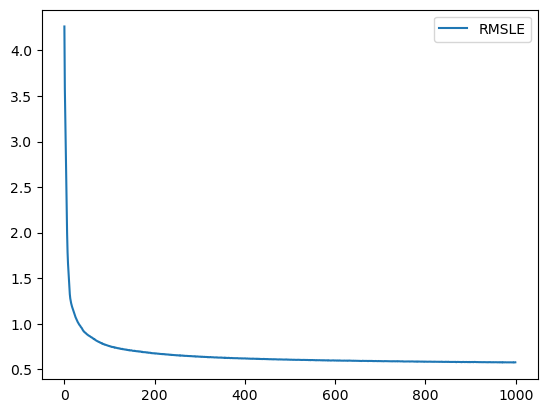

In [21]:
import matplotlib.pyplot as plt # for making figures
plt.plot(running_loss_es, label = "RMSLE")
plt.legend()

In [17]:
# Set the model to evaluation mode
model.eval()
machine_epsilon = 1
# Initialize the total loss and accuracy
total_loss = 0
total_correct = 0
total_samples = 0
machine_epsilon = train_sales_log.std()/10 
# Disable gradient calculation
with torch.no_grad():
    # Loop over the validation set
    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_labels = batch_labels.squeeze(-1)
        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        
        batch_labels = torch.exp(batch_labels)-1
        outputs = torch.exp(outputs)-1
        
        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        # Accumulate the loss
        total_loss += loss.item() * batch_data.size(0)

        # Get the predicted class
        
        
        # Count the number of correct predictions
        total_correct += ((
            (outputs - batch_labels)**2)<machine_epsilon).sum().item()

        # Increment the total number of samples
        total_samples += batch_data.size(0)
        #break
# Calculate the average loss and accuracy over the validation set
average_loss = total_loss / total_samples
accuracy = total_correct / total_samples

# Print the results
print('Validation Loss: {:.4f}'.format(average_loss))

Validation Loss: 0.5987


In [18]:
def evaluate(model_file, val_loader):
    # Load the neural network from file
    model = torch.load(model_file)
    print('Testing model ' + model_file)
    # Get the name of the model
    model_name = model_file.split("/")[-1]
    
    # Evaluate the neural network on the testing set
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
            # Loop over the validation set
        for batch_data, batch_labels in val_loader:
            # Move the data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_data)
            outputs = outputs.squeeze(-1)
            #batch_labels = torch.squeeze(-1)
            
            batch_labels = torch.exp(batch_labels)-1
            outputs = torch.exp(outputs)-1
        

            # Calculate the loss
            loss = criterion(outputs, batch_labels)
            
            # Accumulate the loss
            total_loss += loss.item() * batch_data.size(0)

            # Get the predicted class
            # Count the number of correct predictions
            total_correct += (
                    ((outputs - batch_labels)**2)<machine_epsilon).sum().item()
    
            # Increment the total number of samples
            total_samples += batch_data.size(0)

# Calculate the average loss and accuracy over the validation set
    average_loss = total_loss / total_samples
    #accuracy = total_correct / total_samples

# Print the results
    #accuracy = 0
    print('Validation Loss: {:.4f}'.format(average_loss))
    return average_loss

In [23]:
val_loss = []
num = []
#train_iterations = 1000
for i in range(train_iterations):
    if (i % save_every == 0):
        #print(i)
        num.append(i)
        val_loss.append(evaluate(f'weights/model_weights_{i}.pth',val_loader))


Testing model weights/model_weights_0.pth
Validation Loss: 3.7795
Testing model weights/model_weights_1.pth
Validation Loss: 3.4566
Testing model weights/model_weights_2.pth
Validation Loss: 3.0630
Testing model weights/model_weights_3.pth
Validation Loss: 2.8273
Testing model weights/model_weights_4.pth
Validation Loss: 2.4788
Testing model weights/model_weights_5.pth
Validation Loss: 2.1612
Testing model weights/model_weights_6.pth
Validation Loss: 1.8959
Testing model weights/model_weights_7.pth
Validation Loss: 1.8005
Testing model weights/model_weights_8.pth
Validation Loss: 1.6047
Testing model weights/model_weights_9.pth
Validation Loss: 1.5383
Testing model weights/model_weights_10.pth
Validation Loss: 1.4562
Testing model weights/model_weights_11.pth
Validation Loss: 1.4038
Testing model weights/model_weights_12.pth
Validation Loss: 1.2884
Testing model weights/model_weights_13.pth
Validation Loss: 1.2672
Testing model weights/model_weights_14.pth
Validation Loss: 1.2284
Testi

Validation Loss: 0.7506
Testing model weights/model_weights_123.pth
Validation Loss: 0.7357
Testing model weights/model_weights_124.pth
Validation Loss: 0.7671
Testing model weights/model_weights_125.pth
Validation Loss: 0.7511
Testing model weights/model_weights_126.pth
Validation Loss: 0.7390
Testing model weights/model_weights_127.pth
Validation Loss: 0.7425
Testing model weights/model_weights_128.pth
Validation Loss: 0.7565
Testing model weights/model_weights_129.pth
Validation Loss: 0.7472
Testing model weights/model_weights_130.pth
Validation Loss: 0.7331
Testing model weights/model_weights_131.pth
Validation Loss: 0.7325
Testing model weights/model_weights_132.pth
Validation Loss: 0.7151
Testing model weights/model_weights_133.pth
Validation Loss: 0.7392
Testing model weights/model_weights_134.pth
Validation Loss: 0.7393
Testing model weights/model_weights_135.pth
Validation Loss: 0.7265
Testing model weights/model_weights_136.pth
Validation Loss: 0.7374
Testing model weights/mo

Validation Loss: 0.6864
Testing model weights/model_weights_244.pth
Validation Loss: 0.6790
Testing model weights/model_weights_245.pth
Validation Loss: 0.6620
Testing model weights/model_weights_246.pth
Validation Loss: 0.6808
Testing model weights/model_weights_247.pth
Validation Loss: 0.7046
Testing model weights/model_weights_248.pth
Validation Loss: 0.6630
Testing model weights/model_weights_249.pth
Validation Loss: 0.6724
Testing model weights/model_weights_250.pth
Validation Loss: 0.6580
Testing model weights/model_weights_251.pth
Validation Loss: 0.6563
Testing model weights/model_weights_252.pth
Validation Loss: 0.6623
Testing model weights/model_weights_253.pth
Validation Loss: 0.6743
Testing model weights/model_weights_254.pth
Validation Loss: 0.6851
Testing model weights/model_weights_255.pth
Validation Loss: 0.6637
Testing model weights/model_weights_256.pth
Validation Loss: 0.6745
Testing model weights/model_weights_257.pth
Validation Loss: 0.6635
Testing model weights/mo

Validation Loss: 0.6410
Testing model weights/model_weights_365.pth
Validation Loss: 0.6371
Testing model weights/model_weights_366.pth
Validation Loss: 0.6371
Testing model weights/model_weights_367.pth
Validation Loss: 0.6871
Testing model weights/model_weights_368.pth
Validation Loss: 0.6377
Testing model weights/model_weights_369.pth
Validation Loss: 0.6338
Testing model weights/model_weights_370.pth
Validation Loss: 0.6473
Testing model weights/model_weights_371.pth
Validation Loss: 0.6323
Testing model weights/model_weights_372.pth
Validation Loss: 0.6400
Testing model weights/model_weights_373.pth
Validation Loss: 0.6276
Testing model weights/model_weights_374.pth
Validation Loss: 0.6307
Testing model weights/model_weights_375.pth
Validation Loss: 0.6388
Testing model weights/model_weights_376.pth
Validation Loss: 0.6303
Testing model weights/model_weights_377.pth
Validation Loss: 0.6411
Testing model weights/model_weights_378.pth
Validation Loss: 0.6458
Testing model weights/mo

Validation Loss: 0.6492
Testing model weights/model_weights_486.pth
Validation Loss: 0.6364
Testing model weights/model_weights_487.pth
Validation Loss: 0.6369
Testing model weights/model_weights_488.pth
Validation Loss: 0.6269
Testing model weights/model_weights_489.pth
Validation Loss: 0.6403
Testing model weights/model_weights_490.pth
Validation Loss: 0.6537
Testing model weights/model_weights_491.pth
Validation Loss: 0.6186
Testing model weights/model_weights_492.pth
Validation Loss: 0.6281
Testing model weights/model_weights_493.pth
Validation Loss: 0.6119
Testing model weights/model_weights_494.pth
Validation Loss: 0.6234
Testing model weights/model_weights_495.pth
Validation Loss: 0.6161
Testing model weights/model_weights_496.pth
Validation Loss: 0.6166
Testing model weights/model_weights_497.pth
Validation Loss: 0.6273
Testing model weights/model_weights_498.pth
Validation Loss: 0.6081
Testing model weights/model_weights_499.pth
Validation Loss: 0.6110
Testing model weights/mo

Validation Loss: 0.6204
Testing model weights/model_weights_607.pth
Validation Loss: 0.6103
Testing model weights/model_weights_608.pth
Validation Loss: 0.6214
Testing model weights/model_weights_609.pth
Validation Loss: 0.6151
Testing model weights/model_weights_610.pth
Validation Loss: 0.6226
Testing model weights/model_weights_611.pth
Validation Loss: 0.6076
Testing model weights/model_weights_612.pth
Validation Loss: 0.6171
Testing model weights/model_weights_613.pth
Validation Loss: 0.6128
Testing model weights/model_weights_614.pth
Validation Loss: 0.6109
Testing model weights/model_weights_615.pth
Validation Loss: 0.6214
Testing model weights/model_weights_616.pth
Validation Loss: 0.6216
Testing model weights/model_weights_617.pth
Validation Loss: 0.6039
Testing model weights/model_weights_618.pth
Validation Loss: 0.6028
Testing model weights/model_weights_619.pth
Validation Loss: 0.6234
Testing model weights/model_weights_620.pth
Validation Loss: 0.6132
Testing model weights/mo

Validation Loss: 0.6197
Testing model weights/model_weights_728.pth
Validation Loss: 0.6123
Testing model weights/model_weights_729.pth
Validation Loss: 0.6011
Testing model weights/model_weights_730.pth
Validation Loss: 0.6194
Testing model weights/model_weights_731.pth
Validation Loss: 0.6028
Testing model weights/model_weights_732.pth
Validation Loss: 0.5996
Testing model weights/model_weights_733.pth
Validation Loss: 0.6033
Testing model weights/model_weights_734.pth
Validation Loss: 0.6059
Testing model weights/model_weights_735.pth
Validation Loss: 0.6008
Testing model weights/model_weights_736.pth
Validation Loss: 0.5957
Testing model weights/model_weights_737.pth
Validation Loss: 0.6095
Testing model weights/model_weights_738.pth
Validation Loss: 0.6140
Testing model weights/model_weights_739.pth
Validation Loss: 0.6006
Testing model weights/model_weights_740.pth
Validation Loss: 0.6233
Testing model weights/model_weights_741.pth
Validation Loss: 0.6380
Testing model weights/mo

Validation Loss: 0.6010
Testing model weights/model_weights_849.pth
Validation Loss: 0.6103
Testing model weights/model_weights_850.pth
Validation Loss: 0.5912
Testing model weights/model_weights_851.pth
Validation Loss: 0.5898
Testing model weights/model_weights_852.pth
Validation Loss: 0.5960
Testing model weights/model_weights_853.pth
Validation Loss: 0.5915
Testing model weights/model_weights_854.pth
Validation Loss: 0.6160
Testing model weights/model_weights_855.pth
Validation Loss: 0.6043
Testing model weights/model_weights_856.pth
Validation Loss: 0.5953
Testing model weights/model_weights_857.pth
Validation Loss: 0.6030
Testing model weights/model_weights_858.pth
Validation Loss: 0.5948
Testing model weights/model_weights_859.pth
Validation Loss: 0.6039
Testing model weights/model_weights_860.pth
Validation Loss: 0.5972
Testing model weights/model_weights_861.pth
Validation Loss: 0.6022
Testing model weights/model_weights_862.pth
Validation Loss: 0.6039
Testing model weights/mo

Validation Loss: 0.5913
Testing model weights/model_weights_970.pth
Validation Loss: 0.5921
Testing model weights/model_weights_971.pth
Validation Loss: 0.5985
Testing model weights/model_weights_972.pth
Validation Loss: 0.5838
Testing model weights/model_weights_973.pth
Validation Loss: 0.6050
Testing model weights/model_weights_974.pth
Validation Loss: 0.5917
Testing model weights/model_weights_975.pth
Validation Loss: 0.5879
Testing model weights/model_weights_976.pth
Validation Loss: 0.6031
Testing model weights/model_weights_977.pth
Validation Loss: 0.6154
Testing model weights/model_weights_978.pth
Validation Loss: 0.6055
Testing model weights/model_weights_979.pth
Validation Loss: 0.5760
Testing model weights/model_weights_980.pth
Validation Loss: 0.5893
Testing model weights/model_weights_981.pth
Validation Loss: 0.6110
Testing model weights/model_weights_982.pth
Validation Loss: 0.5830
Testing model weights/model_weights_983.pth
Validation Loss: 0.5984
Testing model weights/mo

In [24]:
print(min(val_loss))


0.5759910686224395


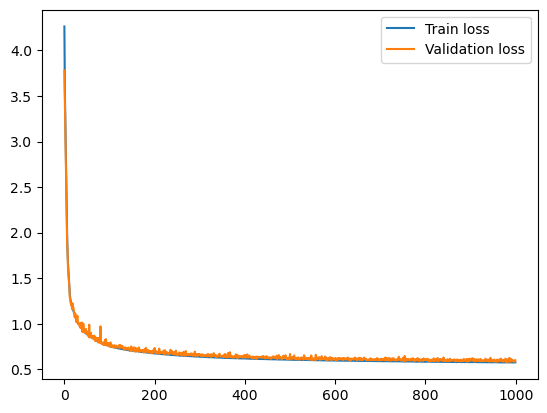

In [25]:
plt.plot(running_loss_es, label = "Train loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend()

In [20]:
!systemctl suspend

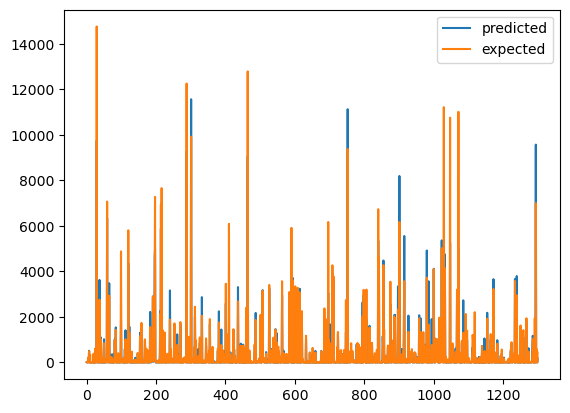

In [26]:
with torch.no_grad():

    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        #batch_labels = torch.squeeze(-1)

        batch_labels = torch.exp(batch_labels)-1
        outputs = torch.exp(outputs)-1


        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        plt.plot(outputs.numpy(), label = "predicted")
        plt.plot(batch_labels.numpy(), label = "expected")
        plt.legend()
        break

loss = 0.07407709956169128


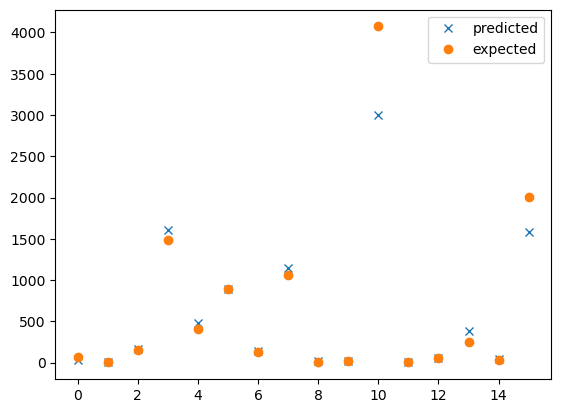

In [32]:
with torch.no_grad():
    evalutaion_val_dataset = val_loader.dataset
    n_samples = len(evalutaion_val_dataset)
    outputs = []
    expections = []
    for i in range(16):
    # Get a random sample
        random_index = int(np.random.random()*n_samples)
        single_example = evalutaion_val_dataset[random_index]
        output = model(single_example[0])
        output = torch.exp(output)+1
        outputs.append(output)
        expections.append(np.exp(single_example[1])+1)
        
    loss = criterion(torch.FloatTensor(outputs).squeeze(-1), torch.FloatTensor(expections).squeeze(-1))
    plt.plot(outputs, label = "predicted", linestyle="",marker="x")
    plt.plot(expections, label = "expected", linestyle="",marker="o")
    plt.legend()
    print(f'loss = {loss}')


In [33]:
evaluate(f'model_weights_979.pth',val_loader)

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_979.pth'

In [34]:
model = torch.load('weights/model_weights_979.pth')

Commiting tests

In [35]:
import pandas as pd

# read the test.csv file
test_df = pd.read_csv('test.csv')

# read the oil.csv file
oil_df = pd.read_csv('oil.csv')

# fill missing values in dcoilwtico column with previous day's value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
test_merged_df = pd.merge(test_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
test_merged_df['dcoilwtico'] = test_merged_df['dcoilwtico'].fillna(method='ffill')





In [36]:
# Load the CSV file using pandas
test_train_df = pd.read_csv('test.csv')
test_oil_df = pd.read_csv('oil.csv')
test_stores_df = pd.read_csv('stores.csv')
# fill missing values in dcoilwtico column with previous day's value
test_oil_df['dcoilwtico'] = test_oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
test_merged_df = pd.merge(test_train_df, test_oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
test_merged_df['dcoilwtico'] = test_merged_df['dcoilwtico'].fillna(method='ffill')
test_merged_df = pd.merge(test_merged_df, test_stores_df, on='store_nbr').sort_values(by='id')

test_df = test_merged_df

# Extract the label column and convert to a PyTorch tensor
test_ids = torch.tensor(test_df['id'].values, dtype=torch.float)
#date = torch.tensor(df['date'].values)
test_store_nbr = torch.tensor(test_df['store_nbr'].values)
#test_train_sales = torch.tensor(test_df['sales'].values, dtype=torch.float)
test_onpromotion = torch.tensor(test_df['onpromotion'].values)
test_dcoilwtico = torch.tensor(test_df['dcoilwtico'].values, dtype=torch.float)

test_df['event_type'] = 'regular day'
test_df['description'] = '0'
for index, row in test_df.iterrows():
    if (row['date'] in data_dict):
        if (row['city'] in data_dict[row['date']]):
            test_df.at[index, 'description'] = data_dict[row['date']][row['city']]['description']
            test_df.at[index, 'event_type'] =  data_dict[row['date']][row['city']]['type']
        if (row['state'] in data_dict[row['date']]):
            test_df.at[index, 'description'] = data_dict[row['date']][row['state']]['description']
            test_df.at[index, 'event_type']  = data_dict[row['date']][row['state']]['type']
        if ('Ecuador' in data_dict[row['date']]):
                test_df.at[index, 'description'] = data_dict[row['date']]['Ecuador']['description']
                test_df.at[index, 'event_type'] = data_dict[row['date']]['Ecuador']['type']
    else:
        test_df.at[index, 'event_type'] = "regular day"

# Convert string dates to datetime objects
test_dates = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
test_month = []
test_day_of_week = []
test_day_of_month = []
test_day_since_paycheck = []
for i in test_dates:
    test_month.append(i.month)
    test_day_of_week.append(i.day_of_week + 1)
    num_days_in_month = monthrange(i.year, i.month)[1]
    test_day_of_month.append(i.day)
    if(num_days_in_month == i.day):
        test_day_since_paycheck.append(0)
    else:
        if (i.day>=15):
            test_day_since_paycheck.append(i.day-15)
        else:
            test_day_since_paycheck.append(i.day)

test_month = torch.FloatTensor(test_month)
test_day_of_week = torch.FloatTensor(test_day_of_week)
test_day_since_paycheck = torch.FloatTensor(test_day_since_paycheck)
test_day_of_month = torch.FloatTensor(test_day_of_month)

#family to tensor
test_family = []
test_family_raw = test_df['family'].values
test_families = sorted(list(set(test_family_raw)))
test_family_stoi = {s:i+1 for i,s in enumerate(test_families)}
for i in test_family_raw:
    test_family.append(family_stoi[i])
test_family = torch.FloatTensor(test_family)

#city to tensor
test_city = []
test_city_raw = test_df['city'].values
test_cities = sorted(list(set(city_raw)))
test_cities_stoi = {s:i+1 for i,s in enumerate(cities)}
#cities_itos = {i:s for s,i in cities_stoi.items()}
for i in test_city_raw:
    test_city.append(test_cities_stoi[i])
test_city = torch.FloatTensor(test_city)

#state to tensor
#test_state_raw = test_df['state'].values
#test_state = []
#test_states = sorted(list(set(test_state_raw)))
#test

#state to tensor
test_state_raw = test_df['state'].values
test_state = []
#states = sorted(list(set(state_raw)))
#states_stoi = {s:i+1 for i,s in enumerate(states)}
for i in test_state_raw:
    test_state.append(states_stoi[i])
test_state = torch.FloatTensor(test_state)

#store type to tensor
test_store_type_raw = test_df['type'].values
test_store_type = []
#store_types = sorted(list(set(store_type_raw)))
#store_types_stoi = {s:i+1 for i,s in enumerate(store_types)}
for i in test_store_type_raw:
    test_store_type.append(store_types_stoi[i])
test_store_type = torch.FloatTensor(test_store_type)

test_event_description_raw = test_df['description']
test_event_description = []
#event_descriptions = sorted(list(set(test_event_description_raw)))
#event_descriptions_stoi = {s:i+1 for i,s in enumerate(event_descriptions)}
for i in test_event_description_raw:
    test_event_description.append(event_descriptions_stoi[i])
test_event_description = torch.FloatTensor(test_event_description)


test_event_type_raw = test_df['event_type']
test_event_type = []
#event_types = sorted(list(set(test_event_type_raw)))
#event_types_stoi = {s:i+1 for i,s in enumerate(event_types)}
for i in test_event_type_raw:
    test_event_type.append(event_types_stoi[i])
test_event_type = torch.FloatTensor(test_event_type)


test_cluster = torch.tensor(test_df['cluster'].values, dtype=torch.float)

In [37]:
#print(train_sales.shape, train_sales.dtype)
print(test_store_nbr.shape, test_store_nbr.dtype)
print(test_onpromotion.shape, test_onpromotion.dtype)
print(test_family.shape, test_family.dtype)
print(test_day_of_week.shape, day_of_week.dtype)
print(test_month.shape, test_month.dtype)
print(test_day_since_paycheck.shape, test_day_since_paycheck.dtype)
print(test_dcoilwtico.shape, dcoilwtico.dtype)
print(test_city.shape, test_city.dtype)
print(test_state.shape, test_state.dtype)
print(test_store_type.shape, test_store_type.dtype)
print(test_cluster.shape, test_cluster.dtype)

torch.Size([28512]) torch.int64
torch.Size([28512]) torch.int64
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32


In [38]:
test_data = torch.cat((test_month.unsqueeze(1), test_day_of_week.unsqueeze(1),test_day_since_paycheck.unsqueeze(1),
                        #test_store_nbr.unsqueeze(1),
                       test_family.unsqueeze(1),  test_onpromotion.unsqueeze(1),
                        test_dcoilwtico.unsqueeze(1),
                       test_city.unsqueeze(1), test_state.unsqueeze(1), test_store_type.unsqueeze(1), test_cluster.unsqueeze(1)
                       test_event_type.unsqueeze(1), test_event_description.unsqueeze(1)
                           ), dim=1)

print(test_data.dtype)
print(test_data.shape, test_data.dtype)
print(test_data.shape, test_data.dtype)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2375917821.py, line 5)

In [27]:
all_predictions = []
submission_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=8)
with torch.no_grad():
    for i, (inputs) in enumerate(submission_loader):
        outputs = model(inputs)
        output = torch.exp(outputs)+1
        #_,predicted = torch.max(outputs.data, 1)
        all_predictions.append(output.item())
        #all_predictions.extend(predicted.numpy())
# Save the predictions to a new CSV file
startId = 3000888
#endId = 
results = [i for i in range(startId,3000888+len(all_predictions))]
df = pd.DataFrame({'id': results, 'sales': all_predictions})
df.to_csv('My_model_predictions.csv', index=False)

In [28]:
all_predictions

[5.857950210571289,
 2.0,
 8.28862190246582,
 2978.365234375,
 2.0,
 533.490234375,
 17.83911895751953,
 860.1469116210938,
 630.85546875,
 282.5483093261719,
 157.57640075683594,
 137.74520874023438,
 4420.60888671875,
 22.235414505004883,
 3.1352550983428955,
 25.550722122192383,
 36.089805603027344,
 2.0,
 225.013427734375,
 21.495405197143555,
 62.506683349609375,
 13.136899948120117,
 95.19330596923828,
 7.150758743286133,
 338.64813232421875,
 362.2543029785156,
 9.042611122131348,
 9.9443998336792,
 443.81243896484375,
 111.09378051757812,
 6632.443359375,
 79.55860137939453,
 22.332046508789062,
 4.524602890014648,
 2.0,
 4.597993850708008,
 1147.9459228515625,
 2.0,
 112.02134704589844,
 6.927706718444824,
 602.2344360351562,
 351.5782165527344,
 176.87417602539062,
 46.131202697753906,
 27.95133399963379,
 2484.265869140625,
 4.052448749542236,
 2.0,
 10.96297550201416,
 21.330751419067383,
 2.0,
 136.9022979736328,
 4.779414176940918,
 35.9719352722168,
 5.1050496101379395,
